In [29]:
# Pytorch通常使用Dataset和DataLoader这两个工具类来构建数据管道。
# Dataset定义了数据集的内容，它相当于一个类似列表的数据结构，
# 具有确定的长度，能够用索引获取数据集中的元素。

# 而DataLoader定义了按batch加载数据集的方法，
# 它是一个实现了__iter__方法的可迭代对象，
# 每次迭代输出一个batch的数据。

# DataLoader能够控制batch的大小，batch中元素的采样方法，
# 以及将batch结果整理成模型所需输入形式的方法，
# 并且能够使用多进程读取数据。在绝大部分情况下，
# 用户只需实现Dataset的__len__方法和__getitem__方法，
# 就可以轻松构建自己的数据集，并用默认数据管道进行加载。

In [30]:
# 一，Dataset和DataLoader概述
# 1，获取一个batch数据的步骤
# 让我们考虑一下从一个数据集中获取一个batch的数据需要哪些步骤。
# (假定数据集的特征和标签分别表示为张量X和Y，数据集可以表示为(X,Y), 假定batch大小为m)

# 1，首先我们要确定数据集的长度n。
# 结果类似：n = 1000。

# 2，然后我们从0到n-1的范围中抽样出m个数(batch大小)。
# 假定m=4, 拿到的结果是一个列表，类似：indices = [1,4,8,9]

# 3，接着我们从数据集中去取这m个数对应下标的元素。
# 拿到的结果是一个元组列表，
# 类似：samples = [(X[1],Y[1]),(X[4],Y[4]),(X[8],Y[8]),(X[9],Y[9])]

# 4，最后我们将结果整理成两个张量作为输出。
# 拿到的结果是两个张量，类似batch = (features,labels) ，
# 其中 features = torch.stack([X[1],X[4],X[8],X[9]])
# labels = torch.stack([Y[1],Y[4],Y[8],Y[9]])

In [31]:
# 2，Dataset和DataLoader的功能分工
# 上述第1个步骤确定数据集的长度是由 Dataset的__len__ 方法实现的。

# 第2个步骤从0到n-1的范围中抽样出m个数的方法是由 
# DataLoader的 sampler和 batch_sampler参数指定的。
# sampler参数指定单个元素抽样方法，一般无需用户设置，
# 程序默认在DataLoader的参数shuffle=True时采用随机抽样，shuffle=False时采用顺序抽样。
# batch_sampler参数将多个抽样的元素整理成一个列表，一般无需用户设置，
# 默认方法在DataLoader的参数drop_last=True时会丢弃数据集
# 最后一个长度不能被batch大小整除的批次，在drop_last=False时保留最后一个批次。

# 第3个步骤的核心逻辑根据下标取数据集中的元素 是由 Dataset的 __getitem__方法实现的。

# 第4个步骤的逻辑由DataLoader的参数collate_fn指定。一般情况下也无需用户设置。

In [55]:
# 3，Dataset和DataLoader的主要接口
# 以下是 Dataset和 DataLoader的核心接口逻辑伪代码，不完全和源码一致。

import torch 
class Dataset(object):
    def __init__(self):
        pass
    
    def __len__(self):
        raise NotImplementedError
        
    def __getitem__(self,index):
        raise NotImplementedError
        

class DataLoader(object):
    def __init__(self,dataset,batch_size,collate_fn,shuffle = True,drop_last = False):
        self.dataset = dataset
        self.sampler =torch.utils.data.RandomSampler if shuffle else \
           torch.utils.data.SequentialSampler
        self.batch_sampler = torch.utils.data.BatchSampler
        self.sample_iter = self.batch_sampler(
            self.sampler(range(len(dataset))),
            batch_size = batch_size,drop_last = drop_last)
        
    def __next__(self):
        indices = next(self.sample_iter)
        batch = self.collate_fn([self.dataset[i] for i in indices])
        return batch

In [56]:
# 二，使用Dataset创建数据集
# Dataset创建数据集常用的方法有：

# 使用 torch.utils.data.TensorDataset 根据Tensor创建数据集
# (numpy的array，Pandas的DataFrame需要先转换成Tensor)。

# 使用 torchvision.datasets.ImageFolder 根据图片目录创建图片数据集。

# 继承 torch.utils.data.Dataset 创建自定义数据集。

# 此外，还可以通过
# torch.utils.data.random_split 将一个数据集分割成多份，
# 常用于分割训练集，验证集和测试集。
# 调用Dataset的加法运算符(+)将多个数据集合并成一个数据集。

In [57]:
import numpy as np 
import torch 
from torch.utils.data import TensorDataset,Dataset,DataLoader,random_split 

In [58]:
# 根据Tensor创建数据集

from sklearn import datasets 
iris = datasets.load_iris()
ds_iris = TensorDataset(torch.tensor(iris.data),torch.tensor(iris.target))

# 分割成训练集和预测集
n_train = int(len(ds_iris)*0.8)
n_valid = len(ds_iris) - n_train
ds_train,ds_valid = random_split(ds_iris,[n_train,n_valid])

print(type(ds_iris))
print(type(ds_train))

<class 'torch.utils.data.dataset.TensorDataset'>
<class 'torch.utils.data.dataset.Subset'>


In [59]:
# 使用DataLoader加载数据集
dl_train,dl_valid = DataLoader(ds_train,batch_size = 8),DataLoader(ds_valid,batch_size = 8)

for features,labels in dl_train:
    print(features, labels)
    break

tensor([[4.6000, 3.2000, 1.4000, 0.2000],
        [5.6000, 2.8000, 4.9000, 2.0000],
        [5.4000, 3.7000, 1.5000, 0.2000],
        [7.7000, 2.8000, 6.7000, 2.0000],
        [4.6000, 3.6000, 1.0000, 0.2000],
        [7.2000, 3.2000, 6.0000, 1.8000],
        [5.5000, 2.4000, 3.7000, 1.0000],
        [5.6000, 2.9000, 3.6000, 1.3000]], dtype=torch.float64) tensor([0, 2, 0, 2, 0, 2, 1, 1], dtype=torch.int32)


In [60]:
# 演示加法运算符（`+`）的合并作用
ds_data = ds_train + ds_valid

print('len(ds_train) = ',len(ds_train))
print('len(ds_valid) = ',len(ds_valid))
print('len(ds_train+ds_valid) = ',len(ds_data))

print(type(ds_data))

len(ds_train) =  120
len(ds_valid) =  30
len(ds_train+ds_valid) =  150
<class 'torch.utils.data.dataset.ConcatDataset'>


In [61]:
# 2，根据图片目录创建图片数据集

import numpy as np 
import torch 
from torch.utils.data import DataLoader
from torchvision import transforms,datasets 
from PIL import Image

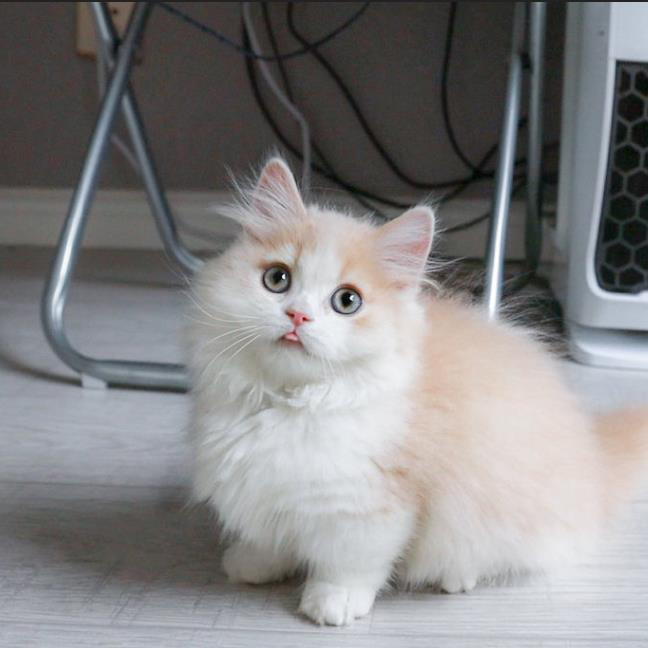

In [62]:
img = Image.open('../data/cat.jpg')
img

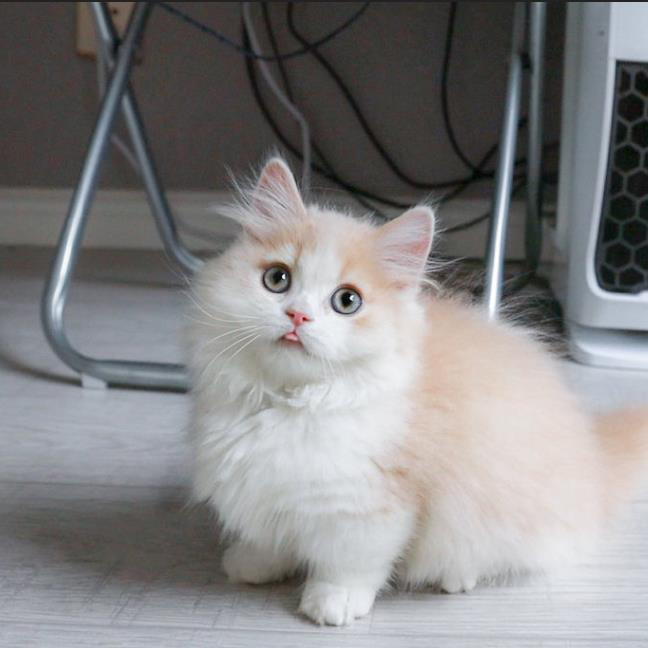

In [63]:
# 随机数值翻转
transforms.RandomVerticalFlip()(img)

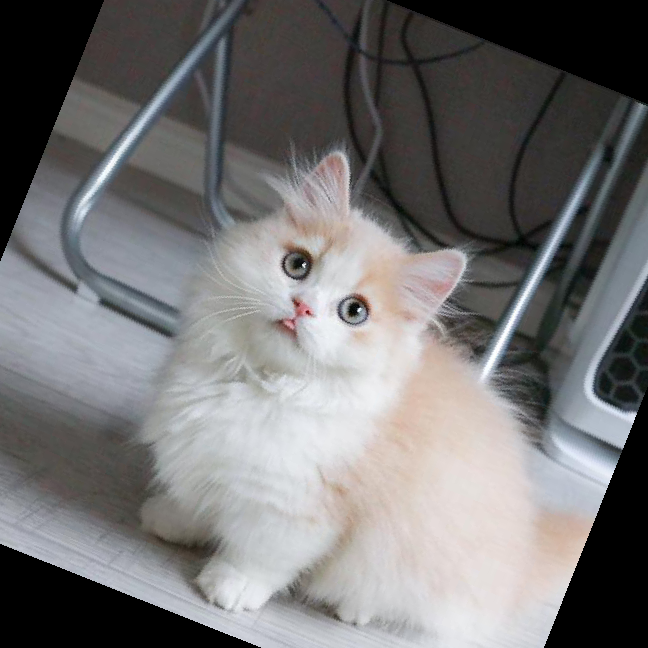

In [64]:
#随机旋转
transforms.RandomRotation(45)(img)